In [1]:
import sys
sys.path.append('../src/')

In [2]:
import os.path as osp

import torch
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score

import torch_geometric.transforms as T

from torch_geometric import seed_everything

import numpy as np
import pandas as pd

import networkx as nx
from torch_geometric.utils.convert import from_networkx

from tqdm import tqdm

from models import LinkGIN, LinkGCN, LinkSAGE, DeepVGAE
from decoders import InnerProductDecoder, CosineDecoder
from explainers import gnnexplainer, ig, deconvolution, backprop
from metrics import ws_confusion_matrix, sbm_confusion_matrix, sensitivity_specificity
from utils import ws_graph_model, sbm_graph_model, get_computation_graph_as_nx
from utils import get_explanation
from plotting import visualize_explanation

from matplotlib import pyplot as plt
import seaborn as sb

In [3]:
sb.set_theme(context='paper', style='white', font_scale=1.5, palette=None)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

graph_model = 'ws'
model_name = 'gin'
explainer = 'deconvolution'
decoder = 'inner'
seed = 0

if model_name == 'vgae':
    sigmoid = False
else:
    sigmoid = True

if model_name == 'vgae':
    return_type = 'probs'
    from train_test import train_vgae as train
    from train_test import test_vgae as test
else:
    return_type = 'raw'
    from train_test import train
    from train_test import test
    
print(seed, graph_model, model_name, explainer, decoder, return_type)  

0 ws gin deconvolution inner raw


In [5]:
seed_everything(seed)
if graph_model == 'ws':
    N = 500
    k = 4
    p = 0.001
    G, A, N, E = ws_graph_model(N=N, k=k, p=p, seed=seed)
if graph_model == 'sbm':
    n_blocks = 3
    avg_block_size = 50
    block_size_dev = 2
    mu = 0.01
    sigma = 0.001
    diag_mu = 0.8
    diag_sigma = 0.1
    G, A, N, E, node_block_labels = sbm_graph_model(seed=seed)

seed_everything(seed)
X = np.eye(N).astype(np.float32)
data = from_networkx(G)
data.x = torch.tensor(X)

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.1, num_test=0.1, is_undirected=True),
])

train_data, val_data, test_data = transform(data)

In [6]:
seed_everything(seed)
if model_name == 'gin':
    model = LinkGIN(train_data.num_features, 128, 64, sim=decoder).to(device)
    tot_epochs = 41
if model_name == 'gcn':
    model = LinkGCN(train_data.num_features, 128, 64, sim=decoder).to(device)
    tot_epochs = 51
if model_name == 'sage':
    model = LinkSAGE(train_data.num_features, 128, 64, sim=decoder).to(device)
    tot_epochs = 101
if model_name == 'vgae':
    if decoder == 'inner':
        model = DeepVGAE(train_data.num_features, 128, 64, InnerProductDecoder()).to(device)
    if decoder == 'cosine':
        model = DeepVGAE(train_data.num_features, 128, 64, CosineDecoder()).to(device)
    tot_epochs = 1001
    
if graph_model == 'sbm':
    tot_epochs = 41

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

seed_everything(0)
for epoch in range(1, tot_epochs):
    loss = train(model, optimizer, train_data)
    if epoch % 20 == 0:
        if model_name == 'vgae':
            val_auc = test(model, train_data, val_data)
            test_auc = test(model, train_data, test_data)
        else:
            val_auc = test(model, val_data)
            test_auc = test(model, test_data)
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
            f'Test: {test_auc:.4f}')

Epoch: 20, Loss: 0.5312, Val: 0.7724, Test: 0.7055
Epoch: 40, Loss: 0.2456, Val: 0.7911, Test: 0.7691


In [7]:
i = 0
edge_label_index = val_data.edge_label_index[:, [i]]
source_node, target_node = edge_label_index.numpy()[:, 0]

target = val_data.edge_label[i].item()
pred = model(train_data.x, train_data.edge_index, edge_label_index).sigmoid().item()
if graph_model == 'ws':
    condition = np.abs(source_node-target_node)<(k/2+1)
if graph_model == 'sbm':
    condition = node_block_labels[source_node]==node_block_labels[target_node]
if condition and int(pred>0.5)==target:
    source_node, target_node, pred, target

    explanation, edge_mask, node_mask = get_explanation(
        explainer, model, train_data, edge_label_index, return_type=return_type
    )

    computation_graph = get_computation_graph_as_nx(source_node, target_node, train_data)

/Users/claudio/opt/anaconda3/envs/linkpred_wc/lib/python3.10/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
/Users/claudio/opt/anaconda3/envs/linkpred_wc/lib/python3.10/site-packages/captum/attr/_core/guided_backprop_deconvnet.py:64: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


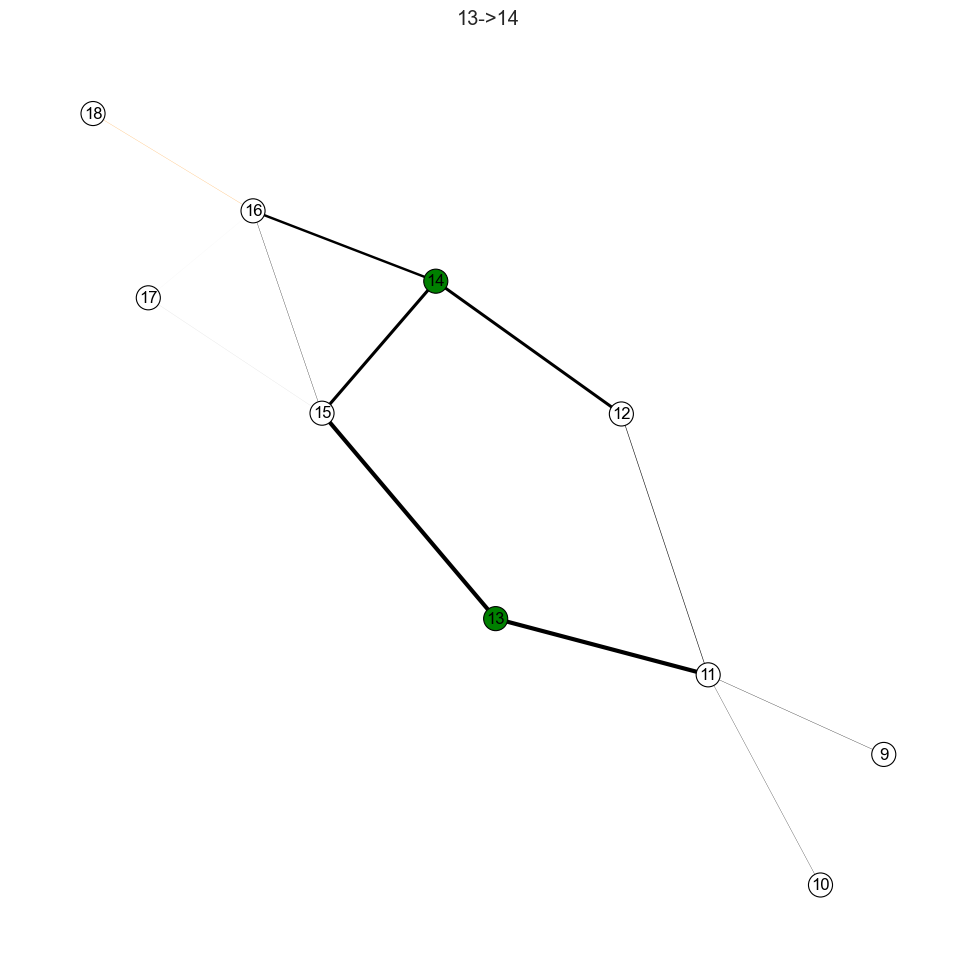

In [8]:
fig = visualize_explanation(computation_graph, train_data.edge_index, edge_mask, source_node, target_node)
plt.tight_layout()
plt.savefig(f"../paper/figs/{graph_model}_{model_name}_{explainer}_{decoder}_explanation_example.png")

In [9]:
edges_to_test = 20
tpr_tnr_curves = []
bt_range = np.linspace(-0.005, 1., 202)
for i in tqdm(range(val_data.edge_label_index.size(1))[:edges_to_test]):
    edge_label_index = val_data.edge_label_index[:, [i]]
    source_node, target_node = edge_label_index.numpy()[:, 0]

    target = val_data.edge_label[i].item()
    if sigmoid:
        pred = model(train_data.x, train_data.edge_index, edge_label_index).sigmoid().item()
    else:
        pred = model(train_data.x, train_data.edge_index, edge_label_index).item()
    if graph_model == 'ws':
        condition = np.abs(source_node-target_node)<(k/2+1)
    if graph_model == 'sbm':
        condition = node_block_labels[source_node]==node_block_labels[target_node]
    if condition and int(pred>0.5)==target:
        source_node, target_node, pred, target
        
        explanation, edge_mask, node_mask = get_explanation(
            explainer, model, train_data, edge_label_index, return_type=return_type
        )

        computation_graph = get_computation_graph_as_nx(source_node, target_node, train_data)

        roc = []
        for binary_threshold in bt_range:
            if graph_model == 'ws':
                conf, tp, tn, fp, fn = ws_confusion_matrix(
                                        train_data.edge_index, 
                                        edge_mask, 
                                        node_mask, 
                                        computation_graph, 
                                        source_node, 
                                        target_node, 
                                        binary_threshold
                                    )
            if graph_model == 'sbm':
                conf, _, _, _, _ = sbm_confusion_matrix(
                                        node_block_labels,
                                        train_data.edge_index,
                                        edge_mask,
                                        node_mask,
                                        computation_graph,
                                        source_node,
                                        target_node,
                                        binary_threshold=binary_threshold
                                    )
            tpr, tnr = sensitivity_specificity(conf)
            roc.append([tpr, tnr])
        tpr_tnr_curves.append(roc)
tpr_tnr_curves = np.array(tpr_tnr_curves)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 15.15it/s]


In [10]:
tpr_curves = pd.DataFrame(tpr_tnr_curves[:, :, 0].T, index=bt_range)
tnr_curves = pd.DataFrame(tpr_tnr_curves[:, :, 1].T, index=bt_range)

roc = pd.DataFrame(tpr_tnr_curves.mean(axis=0), columns=['tpr', 'tnr'], index=bt_range)

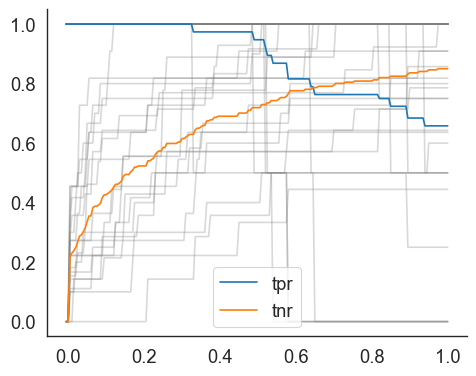

In [25]:
fig, ax = plt.subplots(figsize=(5, 4))
tpr_curves.plot(c='grey', legend=False, alpha=.3, ax=ax)
tnr_curves.plot(c='grey', legend=False, alpha=.3, ax=ax)
roc.plot(ax=ax)
sb.despine()
plt.tight_layout()
plt.savefig(f"../paper/figs/{graph_model}_{model_name}_{explainer}_{decoder}_tpr_tnr_threshold_curve.png")

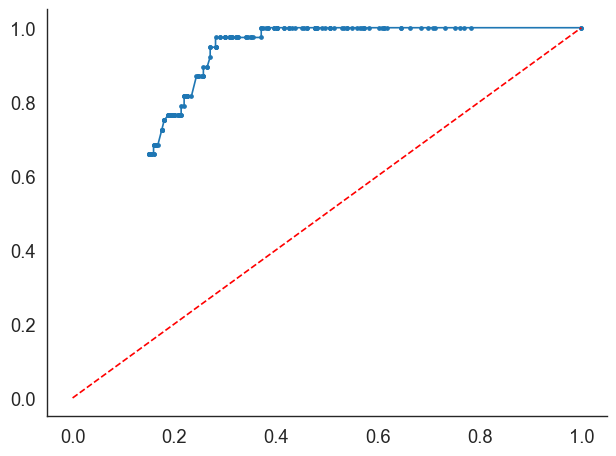

In [33]:
plt.plot(1-tnr_curves.mean(axis=1), tpr_curves.mean(axis=1), marker='.')
plt.plot(np.linspace(0, 1, 11), np.linspace(0, 1, 11), c='r', ls='--')
sb.despine()
plt.tight_layout()